# Suppress gibbs artefact in DWI

In this notebook I will analyse the impacts of gibbs artefact suppression in DWI data.

So let start important some relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dipy.reconst.dki as dki
import dipy.reconst.fwdti as fwdti

from gibbs_removal import gibbs_removal_2d, volume_gibbs_removal, gibbs_removal_2d_weigthing_functions

from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib
from dipy.segment.mask import median_otsu

from dipy.denoise.noise_estimate import estimate_sigma
from dipy.denoise.nlmeans import nlmeans

%matplotlib inline

C:\Users\Rafael\Anaconda\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Just to check that everything is in order, lets first run the gibbs_removal_2d on the phanton used in GibbsPhantomAnalysis.ipynb.

C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


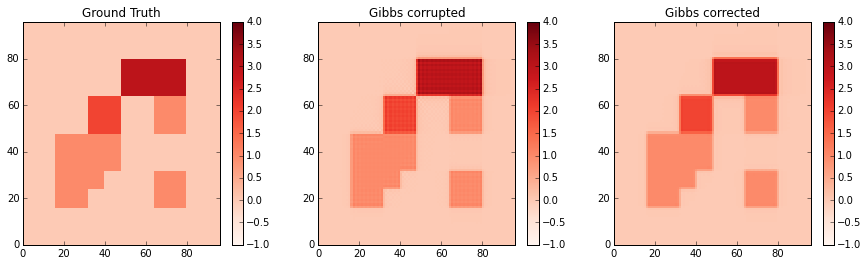

In [2]:
# Produce phantom
Nori = 32
image = np.zeros((6*Nori, 6*Nori))
image[Nori:2*Nori, Nori:2*Nori] = 1
image[3./2*Nori:2*Nori, 2*Nori:5./2*Nori] = 1
image[Nori:2*Nori, 4*Nori:5*Nori] = 1
image[2*Nori:3*Nori, Nori:3*Nori] = 1
image[3*Nori:4*Nori, 2*Nori:3*Nori] = 2
image[3*Nori:4*Nori, 4*Nori:5*Nori] = 1
image[4*Nori:5*Nori, 3*Nori:5*Nori] = 3
c = np.fft.fft2(image)
c = np.fft.fftshift(c)
N = c.shape[0]
c_crop = c[N*0.25: N*0.75, N*0.25: N*0.75]
N = c_crop.shape[0]
image_gibbs = abs(np.fft.ifft2(c_crop)/4)

# Produce ground truth
Nre = 16
image_gt = np.zeros((6*Nre, 6*Nre))
image_gt[Nre:2*Nre, Nre:2*Nre] = 1
image_gt[3./2*Nre:2*Nre, 2*Nre:5./2*Nre] = 1
image_gt[Nre:2*Nre, 4*Nre:5*Nre] = 1
image_gt[2*Nre:3*Nre, Nre:3*Nre] = 1
image_gt[3*Nre:4*Nre, 2*Nre:3*Nre] = 2
image_gt[3*Nre:4*Nre, 4*Nre:5*Nre] = 1
image_gt[4*Nre:5*Nre, 3*Nre:5*Nre] = 3

# Correct gibbs
image_cor, tv = gibbs_removal_2d(image_gibbs)

# plot
fig = plt.figure(figsize = (15, 4))
fig.subplots_adjust(wspace=0.2)

plt.subplot(1, 3, 1)
plt.pcolormesh(image_gt, cmap='Reds', vmin=-1, vmax=4)
plt.axis([0, 96, 0, 96])
plt.colorbar()
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.pcolormesh(image_gibbs, cmap='Reds', vmin=-1, vmax=4)
plt.axis([0, 96, 0, 96])
plt.colorbar()
plt.title('Gibbs corrupted')

plt.subplot(1, 3, 3)
plt.pcolormesh(image_cor, cmap='Reds', vmin=-1, vmax=4)
plt.axis([0, 96, 0, 96])
plt.colorbar()
plt.title('Gibbs corrected')

plt.show()

Now lets load the HCP-like dataset

In [3]:
# fetch_cenir_multib(with_raw=False)

bvals = [200, 400, 1000, 2000]

img, gtab = read_cenir_multib(bvals)

data = img.get_data()

affine = img.get_affine()

Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 


Lets apply the Gibbs removal algorithm ...

In [4]:
data, tv = volume_gibbs_removal(data)

Remove background

In [5]:
data, mask = median_otsu(data, 4, 2, False, vol_idx=[0, 1], dilate=1)

Run DKI on corrected data

In [6]:
dkimodel = dki.DiffusionKurtosisModel(gtab)

dkifit = dkimodel.fit(data)

MK = dkifit.mk(0, 3)

Ploting data for one slice...

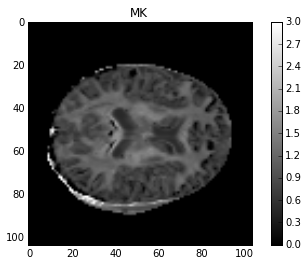

In [7]:
axial_slice = 40

fig = plt.figure(figsize = (15, 4))
fig.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.imshow(MK[:, :, axial_slice], cmap='gray')
plt.colorbar()
plt.title('MK')

Runing everything again with exception of gibbs removal

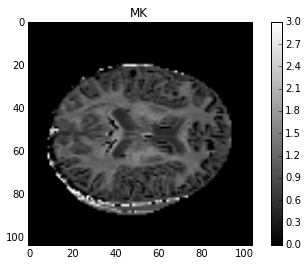

In [10]:
axial_slice = 40

fig = plt.figure(figsize = (15, 4))
fig.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.imshow(MK[:, :, axial_slice], cmap='gray')
plt.colorbar()
plt.title('MK')